### load

In [2]:
## input: 1. summarizedExperiement(SE) obj for chromVAR 2. Jaspar matrix 
## output: 1. motif x cell (z score) 2. plot: ranked           
source("./libs.R")

In [3]:
##------------------------------------------------------------
## inputs
##------------------------------------------------------------

input.chromVar.res.list <- readRDS(file = "../dat/output.jaspar.dev.res.Rdata")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z
input.umap.res <- fread("../dat/1908/Islet_123.MNN_corrected.cluster_labels.filt.txt", 
    header = T) %>% separate(cluster, into = c("cell_type_overall", "subtype"), remove = F)
input.chromVar.jaspar.var <- fread("../dat/1908/output.jaspar.var.res.abcd.csv")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 600 rows [5, 18, 19, 50, 81, 114, 128, 147, 169, 175, 176, 190, 209, 250, 260, 345, 353, 376, 389, 413, ...].”

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>
Islet3-fresh_CTGAAGCTTGCAGCTACTCTCTATTATAGCCT,6.029433,-3.429818,beta_2,beta,2,4.520863,4.152013,0,0,1


[1] 14239    11

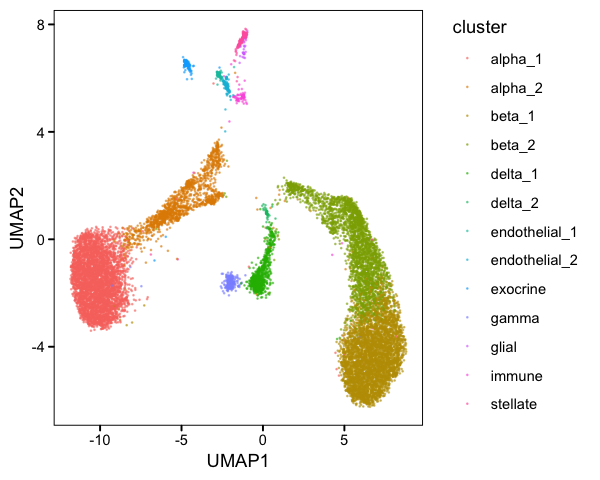

In [22]:
options(repr.plot.width = 5, repr.plot.height = 4)
# filter unkonwn

head(input.umap.res, 1)
dim(input.umap.res)
ggplot(input.umap.res, aes(UMAP1, UMAP2)) + geom_point(aes(color = cluster), size = 0.1, 
    alpha = 0.5) + theme_pubr()

Loading required package: venn



      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7108         709         136         113         205 
      glial      immune    stellate 
         34          58         134 


      alpha        beta       delta endothelial    exocrine       gamma 
       5594        7170         718         157         131         206 
      glial      immune    stellate 
         39          71         153 

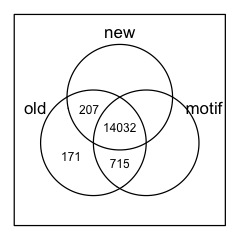

In [5]:
require(venn)
options(repr.plot.width = 2, repr.plot.height = 2)

input.umap.res.old <- fread("../dat/Islet_123.MNN_corrected.UMAP.txt")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z

venn(list(old = input.umap.res.old$barcodes, new = input.umap.res$barcodes, motif = colnames(input.chromVar.jaspar.z)[-1]))
table(input.umap.res %>% filter(barcodes %in% colnames(input.chromVar.jaspar.z)[-1]) %>% 
    pull(cell_type_overall))
table(input.umap.res %>% pull(cell_type_overall))

In [24]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z, 
    umap.res = input.umap.res, rescale = F, cls = rev(cols.sky), bks = c(-4, 0, 4), 
    ...) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    tmp <- tmp %>% mutate(zval = ifelse(zval > bks[3], bks[3], ifelse(zval < bks[1], 
        bks[1], zval)))
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        shape = 16, ...) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_pubr() + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 10, family = "Arial"), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"), plot.margin = unit(c(1, 1, -1, -1), "mm"))
    
    p.default.cluster.motif
}

Joining, by = "barcodes"
Joining, by = "barcodes"
Joining, by = "barcodes"
Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”

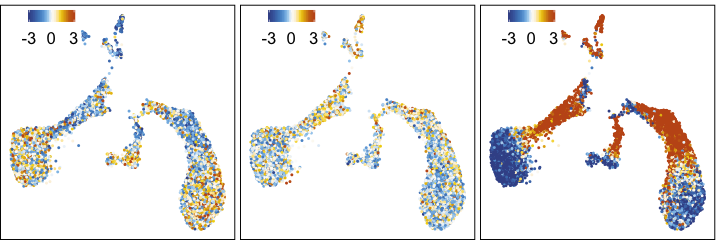

In [25]:
options(repr.plot.width = 6, repr.plot.height = 2)

ps <- lapply(c("RFX3", "XBP1", "FOS::JUN"), fun.plot.project.motif, bks = c(-3, 0, 
    3), size = 0.5)
names(ps) <- c("RFX3", "XBP1", "FOS::JUN")
ggarrange(plotlist = ps, ncol = 3)

Joining, by = "barcodes"
Joining, by = "barcodes"
Joining, by = "barcodes"
Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”

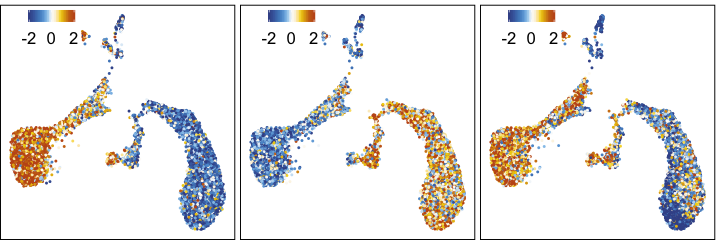

In [27]:
plt.motifs <- c("GATA3", "NKX6-2", "HNF1B")
options(repr.plot.width = 6, repr.plot.height = 2)

ps <- lapply(plt.motifs, fun.plot.project.motif, bks = c(-2, 0, 
    2), size = 0.5)
names(ps) <- plt.motifs
ggarrange(plotlist = ps, ncol = 3)

In [16]:
table(input.umap.res%>%pull(cluster))


      alpha_1       alpha_2        beta_1        beta_2       delta_1 
         4266          1328          4354          2816           683 
      delta_2 endothelial_1 endothelial_2      exocrine         gamma 
           35            62            95           131           206 
        glial        immune      stellate 
           39            71           153 

In [19]:
input.umap.res[is.na(input.umap.res)] <- 0

### T Tests (a_v_g,b_v_d)

In [182]:
input.chromVar.jaspar.z <- data.table(assays(input.chromVar.res.list$dev)$z,keep.rownames = T)
class(input.chromVar.jaspar.z)
head(rownames(input.chromVar.jaspar.z))

[1] "data.table" "data.frame"

[1] "1" "2" "3" "4" "5" "6"

In [183]:
# aggregate data --------------------------------------------------------------
# melt
input.chromVar.jaspar.z.agg <- melt(input.chromVar.jaspar.z, id = "rn", variable.name = "barcodes", 
    value.name = "zval")

# add celltype
input.chromVar.jaspar.z.agg <- merge(input.chromVar.jaspar.z.agg, input.umap.res) 


head(input.chromVar.jaspar.z.agg,1)
dim(input.chromVar.jaspar.z.agg)
dim(input.chromVar.jaspar.z)
table(input.chromVar.jaspar.z.agg%>%pull(cell_type_overall))

barcodes,rn,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,MA0025.1_NFIL3,-0.3430543,6.975175,-3.232226,beta_1,beta,1,3.694693,3.384174,1,0,0


[1] 5416738      13

[1]   386 14749


      alpha        beta       delta endothelial    exocrine       gamma 
    2136510     2744074      273674       52496       43618       79130 
      glial      immune    stellate 
      13124       22388       51724 

In [184]:
input.chromVar.jaspar.z.agg <- input.chromVar.jaspar.z.agg[complete.cases(input.chromVar.jaspar.z.agg), 
   ] %>% separate(rn, into = c("id", "name"), sep = "_")
range(input.chromVar.jaspar.z.agg$zval)
dim(input.chromVar.jaspar.z.agg)
head(input.chromVar.jaspar.z.agg,1)

[1] -17.90770  33.67385

[1] 5206754      14

barcodes,id,name,zval,UMAP1,UMAP2,cluster,cell_type_overall,subtype,log10_n_counts,log10_n_peaks,Islet1,Islet2,Islet3
Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT,MA0025.1,NFIL3,-0.3430543,6.975175,-3.232226,beta_1,beta,1,3.694693,3.384174,1,0,0


In [82]:
motif ='NFIL3'
table(input.chromVar.jaspar.z.agg %>% filter(name == motif)%>%pull(cell_type_overall))
table(input.chromVar.jaspar.z.agg%>%pull(cell_type_overall))


      alpha        beta       delta endothelial 
       5535        7109         709         136 


      alpha        beta       delta endothelial 
    2136510     2744074      273674       52496 

In [202]:
require(parallel)
celltype.test.all <- list(alpha_vs_gamma = c("alpha", "gamma"), beta_vs_delta = c("beta", 
    "delta"))
ttest.res <- do.call(rbind, lapply(names(celltype.test.all), function(ntest) {
    # cells <- c('beta', 'delta')
    celltype.test <- celltype.test.all[[ntest]]
    test.motifs <- input.chromVar.jaspar.z.agg %>% filter(cell_type_overall %in% 
        celltype.test) %>% pull(name) %>% unique
    ttest.res <- do.call(rbind, mclapply(test.motifs, function(motif) {
        pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
            celltype.test)
        test.res <- t.test(pd %>% filter(cell_type_overall == celltype.test[1]) %>% 
            select(zval), pd %>% filter(cell_type_overall == celltype.test[2]) %>% 
            select(zval))
        (data.frame(`motif` = motif, mean_x = test.res$estimate[1], mean_y = test.res$estimate[2], 
            pval = test.res$p.value/2))
    }, mc.cores = 10)) %>% mutate(test = ntest)
}))
head(ttest.res,1)
head(ttest.res%>%filter(test=='beta_vs_delta'),1)

motif,mean_x,mean_y,pval,test
NFIL3,-0.2479951,0.05709858,3.703684e-05,alpha_vs_gamma


motif,mean_x,mean_y,pval,test
NFIL3,0.203819,0.0655054,0.0009128493,beta_vs_delta


In [333]:
ttest.res <- ttest.res %>% group_by(test) %>% mutate(FDR = p.adjust(pval, "BH"), 
    padj = p.adjust(pval, "bonferroni"))

fwrite(ttest.res, "~/Dropbox (UCSD_Epigenomics)/workReports/2019-08-27_islet/chromVar_ttest_res.csv")

#### add motif annotation

In [7]:
require(tidyverse)
require(data.table)

In [15]:
ttest.res <- fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019_Q3/2019-08-27_islet/chromVar_ttest_res.csv") %>% 
    rename(enrichedIn = "enriched")
ttest.res %>% head(1)
ttest.res %>% pull(id) %>% unique %>% length
ttest.res %>% nrow

rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1


[1] 386

[1] 772

In [17]:
## from one vs other prevous.res <-
ttest.res<- ttest.res %>% left_join(fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/fig1E_one_vs_other.csv") %>% 
    select(jaspar.id, family.id, family.name, class.id, class.name, superclass.id, 
        superclass.name) %>% unique, by = c(id = "jaspar.id"))
ttest.res%>%head(1)
ttest.res%>%nrow


rank,motif,mean_x,mean_y,pval,test,x,y,enrichedIn,FDR,padj,diff,id,family.id,family.name,class.id,class.name,superclass.id,superclass.name
<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>
1,MAFG,0.4259281,-2.01688,1.42e-74,alpha_vs_gamma,alpha,gamma,alpha,5.4812e-72,5.4812e-72,2.442808,MA0659.1,1.1.3,Maf-related,1.1,Basic leucine zipper factors (bZIP),1,Basic domains


[1] 790

In [36]:
ntest = "delta"
ttest.res %>% filter(test == sub("_[bdga]$", "", all.test[[ntest]]) & enrichedIn == 
    "ntest")%>%head(1)

[1] "beta_vs_delta"

In [39]:
(all.test <- c("beta_vs_delta_d", "beta_vs_delta_b", "alpha_vs_gamma_g", "alpha_vs_gamma_a"))
names(all.test) <- c("delta", "beta", "gamma", "alpha")
ttest.res <- ttest.res %>% group_by(test) %>% arrange(enrichedIn, pval, desc(mean_x))
ttest.res.list <- lapply(names(all.test), function(ntest) ttest.res %>% filter(test == 
    sub("_[bdga]$", "", all.test[[ntest]]) & enrichedIn == ntest) %>% select(-rank) %>% 
    rename(`mean_x-mean_y` = "diff"))
names(ttest.res.list) <- as.character(all.test)
require(writexl)
write_xlsx(ttest.res.list, "~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/fig1S_one_vs_one.xlsx")
fwrite(ttest.res, "~/Dropbox (UCSD_Epigenomics)/workReports/2019-10_islet_rev/fig1S_one_vs_one.csv")

[1] "beta_vs_delta_d"  "beta_vs_delta_b"  "alpha_vs_gamma_g" "alpha_vs_gamma_a"